---
title: "Ensemble, bagging and random forest"
date: 2019-01-25T19:14:46+05:30
draft: False
author: "Nitin Patil"

---

# Ensemble

An ensemble is a set of elements that collectively contribute to a whole. A familiar example is a musical ensemble, which blends the sounds of several musical instruments to create harmony, or architectural ensembles. In ensembles, the (whole) harmonious outcome is more important than the performance of any individual part.

In machine learning the goal of ensembling is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.


Two broad ensemble methods are:

1. Averaging methods: the basic principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.

Examples: Bagging methods, Forests of randomized trees, …

2. Boosting methods:
base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.

Examples: AdaBoost, Gradient Tree Boosting, …

# Bias-Variance Decomposition

<img src="bias_variance.png" width="480">

# Bagging

In bagging we build several instances of black-box estimator on random subsets of training data and then aggregate their idividual predictions to form a final prediction.

As bagging provide a way to reduce overfitting (variance), by introducing randomization while base model creation, bagging methods works best with strong and complex models like fully developed decision trees. In contrast boosting methods usually works best with weak models like shallow decision trees.

The efficiency of bagging comes from the fact that the individual models are quite different due to the different training data and their errors cancel each other out during voting. Additionally, outliers are likely omitted in some of the training bootstrap samples.

Scikit-learn offers bagging meta-estimator ([BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) and [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor)), which takes user-specified base estimator as input . It also takes parameters like `max_samples` and `max_features` to draw random subsets of samples. Parameters `bootstrap` and `bootstrap_features` control whether samples and features are drawn with or without replacement. When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting `oob_score=True`.

In [56]:
# Bagging KNN estimator for bootstrap samples of 50% of actual and 
# random 50% of features
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5,
                            bootstrap=True)

## Bootstrapping

Generate sub-sample of size same as the original input sample size with replacement i.e. with repeated occurrences of individual observations.

Suppose you have a basket of $N$ balls marked with unique id. You randomly picked one ball out of them. Note down the ball id. Then put the ball back in basket. Do this process $N$ times. At every selection each ball has an equal probability of being selected which is $\frac{1}{N}$. At the end you have a sample of size $N$ but some of them are duplicated.

Approximately 63% of data gets selected in bootstrap sample and the left out 37% data can be used for validation with `oob_score` parameter.

In [ ]:
# Sub-sample with replacement
>>> np.random.seed(RANDOM_STATE)
>>> np.random.randint(0, 10, 10)
array([1, 6, 6, 9, 0, 6, 4, 7, 4, 7])

# Sub-sample with replacement
>>> np.random.seed(RANDOM_STATE)
>>> np.random.choice(range(10), 10, replace=True)
array([1, 6, 6, 9, 0, 6, 4, 7, 4, 7])

# Sub-sample without replacement
>>> np.random.seed(RANDOM_STATE)
>>> np.random.choice(range(10), 10, replace=False)
array([7, 2, 5, 3, 4, 0, 9, 8, 6, 1])

## Random forest

A random forest bags number of decision trees. Sub-samples are drawn with replacement keeping their size same as the original input sample size. Sub-samples have random subset of features. 

As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

The scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

## Extremely Randomized Trees

It differs with Random forest in the way tree splits are computed. The split thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

## Parameters

Important parameters to adjust when using these methods

- `n_estimators` - number of trees in the forest
- `max_features` - size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias.
- `max_depth` - The maximum depth of the tree
- `min_samples_split` - The minimum number of samples required to split an internal node

## Feature importance
Feature used at the top node splits are relative more importance than the bottom node split features.


## Random Forest implementation

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# we will use our Decision Tree
from mllearn import tree

In [57]:
RANDOM_STATE=17

In [45]:
class RandomForest(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=10, max_features=10, 
                 random_state=RANDOM_STATE, debug=False):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.debug = debug
        
        self.trees = []
        self.feat_ids_by_tree = []
        

    def fit(self, X, y):
        
        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values
            
        if isinstance(y, pd.Series):
            y = y.values
        
        # Validate features count
        assert(X.shape[1] >=  self.max_features)
        
        for i in range(self.n_estimators):
            np.random.seed(self.random_state+i)
            
            # select max_features features without replacement (means without repeated occurrence of feature)
            feat_indices = np.random.choice(range(X.shape[1]), size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_indices)
            if self.debug: print(f'Tree {i+1} feature indices : {feat_indices}')
            
            # make a bootstrap sample (i.e. sampling with replacement, means repeated occurrence of instances)
            # of training instances.
            indices = list(np.random.choice(X.shape[0], size=X.shape[0], replace=True))
            sample = X[indices,:][:,feat_indices] # [indices,:] - get specific rows with all columns
                                                  # [:,feat_indices] - then get specific columns keeping all rows
            if self.debug: print(f'Tree {i+1} X shape : {sample.shape}')
            
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            tree.fit(sample, y[indices])
            self.trees.append(tree)
            
        return self
    
    def predict_proba(self, X):
        # You code here
        if isinstance(X, pd.core.frame.DataFrame):
            X = X.values
            
        prob = []
        for i, tree in enumerate(self.trees):
            p = tree.predict_proba(X[:, self.feat_ids_by_tree[i]])
            if self.debug: print(f'Tree {i+1} prob shape : {p.shape}')
            prob.append(p)
            
        return np.mean(prob, axis=0)

### Test the implementation

In [42]:
X_train, X_test, y_train, y_test = classification_dataset()

In [41]:
def classification_dataset():
    ''' Prepare a synthetic data for classification '''
    X, y = make_classification(n_features=2, n_redundant=0, n_samples=400,
                            random_state=RANDOM_STATE)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=RANDOM_STATE)

    return X_train, X_test, y_train, y_test

In [43]:
def print_results_rf(model):
    prob_pred = model.predict_proba(X_test)
    y_pred = np.argmax(prob_pred,axis=1)
    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy:", accuracy)

    if (sum(np.argmax(prob_pred,axis=1) - y_pred) == 0):
        print('predict_proba works!')

    plt.suptitle("Accuracy = {0:.2f}".format(accuracy))
    plt.subplot(121)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
    plt.title('Predicted class labels')
    plt.axis('equal')
    plt.subplot(122)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
    plt.title('True class labels')
    plt.axis('equal');

Accuracy: 0.8666666666666667
predict_proba works!


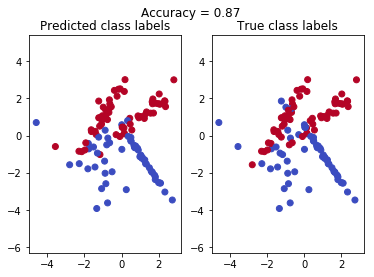

In [44]:
rf = RandomForest(n_estimators=10, max_depth=7, max_features=2, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
print_results_rf(rf)

## References

- https://mlcourse.ai/
- https://scikit-learn.org/stable/modules/ensemble.html